In [2]:
import pandas as pd
import numpy as np
import faiss
import time
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import GridSearchCV, cross_val_score
from catboost import CatBoostClassifier
import warnings
import gc
warnings.simplefilter("ignore", UserWarning)


PATH = '/home/maria_grig/projects/master/stock_matching/'

In [3]:
n_neigbours = 20

In [4]:
features = pd.read_csv(PATH + 'all_features_train.csv', index_col=0)
target = pd.read_csv(PATH + 'target_train.csv', index_col=0)

In [5]:
features['idx_faiss'] = pd.read_csv(PATH + 'faiss_idx_train.csv', index_col=0)
#df['target'] = pd.read_csv(PATH + 'target_train.csv', index_col=0)

In [6]:
drop_cols = ['6','21','25','70']

## CatBoost ranking

In [7]:
X = np.array(features)
y = np.array(target)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2,                         
                                                    random_state=42,
                                                   stratify=y)

In [9]:
print(X_train.shape)
print(X_test.shape)

(1600000, 145)
(400000, 145)


In [10]:
model = CatBoostClassifier(verbose=200, depth=7, 
                           iterations=1500, 
                           random_seed=42, 
                           loss_function='Logloss',
                           bootstrap_type='Bernoulli',
                           leaf_estimation_method='Newton',
                           boosting_type='Ordered')
model.fit(X_train, y_train)

0:	learn: 0.6229655	total: 1.2s	remaining: 29m 51s
200:	learn: 0.0246202	total: 3m 45s	remaining: 24m 16s
400:	learn: 0.0115726	total: 7m 33s	remaining: 20m 42s
600:	learn: 0.0075576	total: 11m 10s	remaining: 16m 42s
800:	learn: 0.0062195	total: 15m	remaining: 13m 5s
1000:	learn: 0.0055168	total: 19m 4s	remaining: 9m 30s
1200:	learn: 0.0049765	total: 22m 45s	remaining: 5m 39s
1400:	learn: 0.0045950	total: 26m 9s	remaining: 1m 50s
1499:	learn: 0.0044480	total: 27m 49s	remaining: 0us


In [11]:
pred = model.predict(X_test)
print(precision_score(y_test, pred))
print(accuracy_score(y_test, pred))

0.9494482022071912
0.9984775


In [12]:
prob = model.predict_proba(X)[:, 1]
prob

array([5.42662713e-05, 1.14332835e-04, 1.91486284e-05, ...,
       2.51302679e-05, 5.55846874e-05, 3.80376215e-03])

In [13]:
features['prob'] = prob
features['target'] = target

In [14]:
del X_train, X_test

146
0.0    0.96871
1.0    0.03129
Name: proportion, dtype: float64


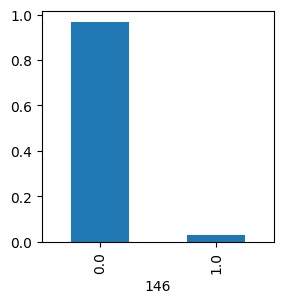

In [21]:
plt.figure(figsize=(3,3))
class_frequency = df[146].value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar');  

In [17]:
best_candidates_list = []
for i in tqdm(range((len(features)// n_neigbours))):
    best_c = features[n_neigbours*i:n_neigbours*(i+1)].sort_values(by='prob', ascending=False)[:5]
    best_candidates_list.append(best_c)

  0%|          | 0/100000 [00:00<?, ?it/s]

In [22]:
df = pd.DataFrame(np.concatenate(best_candidates_list))
df.to_csv(PATH + 'best_candidates_train.csv')